## X-Ray Abnormality Detection | CNN

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification, all study types](#Random-Classification,-all-study-types)
 * [CNN architecture with sensible defaults, all study types](#CNN-architecture-with-sensible-defaults,-all-study-types)
 * [Only on XR_SHOULDER study type](#Only-on-XR_SHOULDER-study-type)
 * [Only on XR_ELBOW study type](#Only-on-XR_ELBOW-study-type)
 * [Only on XR_HUMERUS study type](#Only-on-XR_HUMERUS-study-type)
 * [Only on XR_HAND study type](#Only-on-XR_HAND-study-type)
 * [Only on XR_WRIST study type](#Only-on-XR_WRIST-study-type)
 * [Only on XR_FOREARM study type](#Only-on-XR_FOREARM-study-type)
 * [Only on XR_FINGER study type](#Only-on-XR_FINGER-study-type)


In [1]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

from utils import (
    clean_up,
    F1Score,
    inspect_df,
    plot_metrics,
)

pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-04-02 23:27:35.794210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 23:27:35.800311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 23:27:35.800471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [8]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [9]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [10]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [11]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [12]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [13]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [14]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [15]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [16]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

Since image directory follows a specific ontological structure (7 upper extremities aka study types) we will shuffle the training dataset beforehand in order to ensure that the validation set will be representable of all study types. 

This is due to the fact that tf.keras `tf.keras.preprocessing.image.ImageDataGenerator` first performs the train-val split and then shuffles per epoch by default.

In [17]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


### Baseline Performance

We will try to establish, through some very basic architectures (from naive random classification to a simple CNN) the complexity of the problem.

This is very important, as it will serve as a reference on our efforts to find a better-suited architecture for the problem.

#### Random Classification, all study types

In [21]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self) -> float:

        return random.random()

In [22]:
model = RandomClassifier()


labels = validationset.labels
preds = [model.predict() for _ in labels]

In [23]:
cohen_kappa_score(
    labels,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds),
)

0.005665034020382986

#### CNN architecture with sensible defaults, all study types

In [24]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-04-02 23:27:37.279193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 23:27:37.279972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 23:27:37.280255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 23:27:37.280449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [25]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="1st-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.25,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="2nd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.25,
                name="2nd-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="3rd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="3rd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="3rd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.25,
                name="3rd-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="4th-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="4th-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="4th-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.25,
                name="4th-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=128,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [26]:
model = make_cnn_model()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 16)      448       
                                                                 
 1st-batch-norm (BatchNormal  (None, 224, 224, 16)     64        
 ization)                                                        
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 16)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 32)      4640      
                                                                 
 2nd-batch-norm (BatchNormal  (None, 112, 112, 32)     1

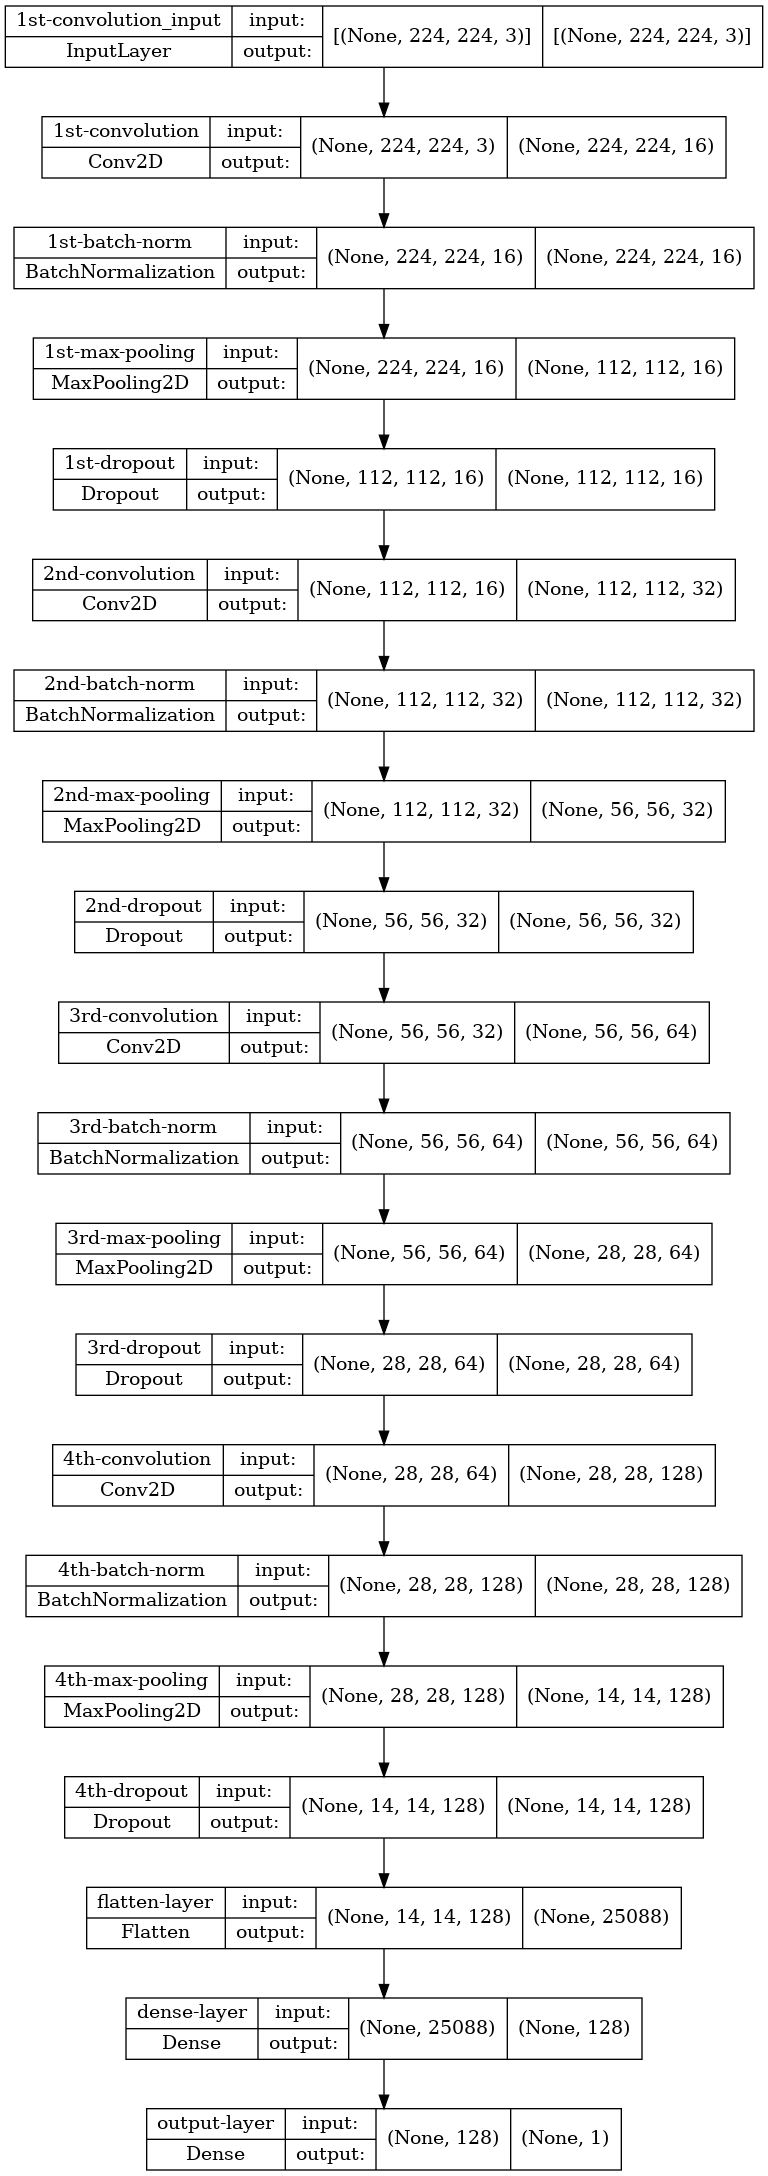

In [28]:
tf.keras.utils.plot_model(
    model,
    to_file=f"../static/cnn-all-study-types-{model.count_params()}.png",
    show_shapes=True,
    show_layer_names=True,
)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
    baseline=0.0,
    restore_best_weights=True,
)

In [30]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=7,
    mode="max",
    factor=0.2,
    min_lr=1e-10,
)

In [31]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-04-02 23:27:41.200093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


921/921 [==============================] - 330s 354ms/step - loss: 3.4482 - tp: 2147.0000 - fp: 2276.0000 - tn: 15240.0000 - fn: 9784.0000 - binary_acc: 0.5905 - precision: 0.4854 - recall: 0.1800 - f1_score: 0.2626 - roc_auc: 0.5799 - pr_auc: 0.4618 - cohen_kappa: 0.0556 - val_loss: 2.4831 - val_tp: 69.0000 - val_fp: 92.0000 - val_tn: 4327.0000 - val_fn: 2873.0000 - val_binary_acc: 0.5972 - val_precision: 0.4286 - val_recall: 0.0235 - val_f1_score: 0.0445 - val_roc_auc: 0.5430 - val_pr_auc: 0.4220 - val_cohen_kappa: 0.0031 - lr: 1.0000e-04
Epoch 2/100
921/921 [==============================] - 312s 339ms/step - loss: 1.6807 - tp: 1410.0000 - fp: 1301.0000 - tn: 16215.0000 - fn: 10521.0000 - binary_acc: 0.5985 - precision: 0.5201 - recall: 0.1182 - f1_score: 0.1926 - roc_auc: 0.6078 - pr_auc: 0.4895 - cohen_kappa: 0.0501 - val_loss: 1.4554 - val_tp: 15.0000 - val_fp: 35.0000 - val_tn: 4384.0000 - val_fn: 2927.0000 - val_binary_acc: 0.5976 - val_precision: 0.3000 - val_recall: 0.0051 - 

Epoch 16/100
921/921 [==============================] - 303s 329ms/step - loss: 0.6153 - tp: 6405.0000 - fp: 2093.0000 - tn: 15423.0000 - fn: 5526.0000 - binary_acc: 0.7413 - precision: 0.7537 - recall: 0.5368 - f1_score: 0.6270 - roc_auc: 0.7922 - pr_auc: 0.7578 - cohen_kappa: 0.4374 - val_loss: 0.6455 - val_tp: 1428.0000 - val_fp: 542.0000 - val_tn: 3877.0000 - val_fn: 1514.0000 - val_binary_acc: 0.7207 - val_precision: 0.7249 - val_recall: 0.4854 - val_f1_score: 0.5814 - val_roc_auc: 0.7564 - val_pr_auc: 0.7180 - val_cohen_kappa: 0.3839 - lr: 1.0000e-04
Epoch 17/100
921/921 [==============================] - 304s 330ms/step - loss: 0.6174 - tp: 6455.0000 - fp: 2089.0000 - tn: 15427.0000 - fn: 5476.0000 - binary_acc: 0.7431 - precision: 0.7555 - recall: 0.5410 - f1_score: 0.6305 - roc_auc: 0.7938 - pr_auc: 0.7566 - cohen_kappa: 0.4418 - val_loss: 0.6531 - val_tp: 1349.0000 - val_fp: 561.0000 - val_tn: 3858.0000 - val_fn: 1593.0000 - val_binary_acc: 0.7074 - val_precision: 0.7063 - va

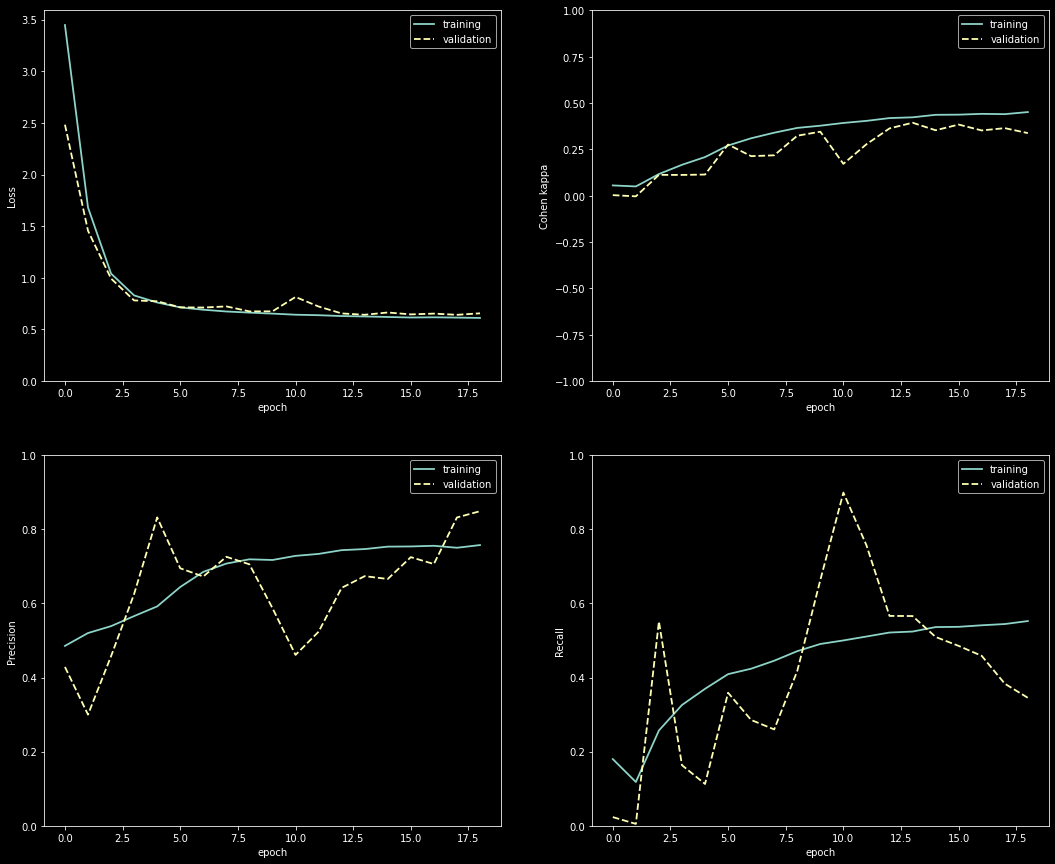

In [32]:
plot_metrics(history)

In [33]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

231/231 [==============================] - 62s 268ms/step - loss: 0.6457 - tp: 1627.0000 - fp: 804.0000 - tn: 3615.0000 - fn: 1315.0000 - binary_acc: 0.7121 - precision: 0.6693 - recall: 0.5530 - f1_score: 0.6056 - roc_auc: 0.7598 - pr_auc: 0.7163 - cohen_kappa: 0.3822


In [34]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6456658244132996
tp          : 1627.0
fp          : 804.0
tn          : 3615.0
fn          : 1315.0
binary_acc  : 0.7121315002441406
precision   : 0.6692718863487244
recall      : 0.5530251264572144
f1_score    : 0.6056206822395325
roc_auc     : 0.7597877383232117
pr_auc      : 0.7162660360336304
cohen_kappa : 0.38217705488204956


In [35]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-all-study-types-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-all-study-types-{model.count_params()}.h5")
model.save(f"../models/cnn-all-study-types-{model.count_params()}.h5")

Saving: ../models/cnn-all-study-types-3309921.h5


In [36]:
clean_up(model)

#### Only on XR_SHOULDER study type

In [37]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6704 validated image filenames belonging to 2 classes.


In [38]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1675 validated image filenames belonging to 2 classes.


In [39]:
model = make_cnn_model()

In [40]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
210/210 [==============================] - 74s 346ms/step - loss: 4.4506 - tp: 3373.0000 - fp: 2354.0000 - tn: 5419.0000 - fn: 2919.0000 - binary_acc: 0.6251 - precision: 0.5890 - recall: 0.5361 - f1_score: 0.5613 - roc_auc: 0.6721 - pr_auc: 0.6232 - cohen_kappa: 0.2352 - val_loss: 4.4687 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 857.0000 - val_fn: 818.0000 - val_binary_acc: 0.5116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5404 - val_pr_auc: 0.5066 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 70s 334ms/step - loss: 3.6308 - tp: 1896.0000 - fp: 1423.0000 - tn: 1931.0000 - fn: 1454.0000 - binary_acc: 0.5709 - precision: 0.5713 - recall: 0.5660 - f1_score: 0.5686 - roc_auc: 0.5931 - pr_auc: 0.5884 - cohen_kappa: 0.1417 - val_loss: 3.5171 - val_tp: 98.0000 - val_fp: 72.0000 - val_tn: 785.0000 - val_fn: 720.0000 - val_binary_acc: 0.5272 - val_precision: 0.576

Epoch 16/100
210/210 [==============================] - 70s 335ms/step - loss: 0.9135 - tp: 2104.0000 - fp: 954.0000 - tn: 2400.0000 - fn: 1246.0000 - binary_acc: 0.6718 - precision: 0.6880 - recall: 0.6281 - f1_score: 0.6567 - roc_auc: 0.7322 - pr_auc: 0.7405 - cohen_kappa: 0.3436 - val_loss: 1.0506 - val_tp: 440.0000 - val_fp: 247.0000 - val_tn: 610.0000 - val_fn: 378.0000 - val_binary_acc: 0.6269 - val_precision: 0.6405 - val_recall: 0.5379 - val_f1_score: 0.5847 - val_roc_auc: 0.6697 - val_pr_auc: 0.6277 - val_cohen_kappa: 0.2506 - lr: 1.0000e-04
Epoch 17/100
210/210 [==============================] - 71s 338ms/step - loss: 0.8708 - tp: 2117.0000 - fp: 866.0000 - tn: 2488.0000 - fn: 1233.0000 - binary_acc: 0.6869 - precision: 0.7097 - recall: 0.6319 - f1_score: 0.6686 - roc_auc: 0.7495 - pr_auc: 0.7651 - cohen_kappa: 0.3738 - val_loss: 1.0782 - val_tp: 377.0000 - val_fp: 224.0000 - val_tn: 633.0000 - val_fn: 441.0000 - val_binary_acc: 0.6030 - val_precision: 0.6273 - val_recall: 0.

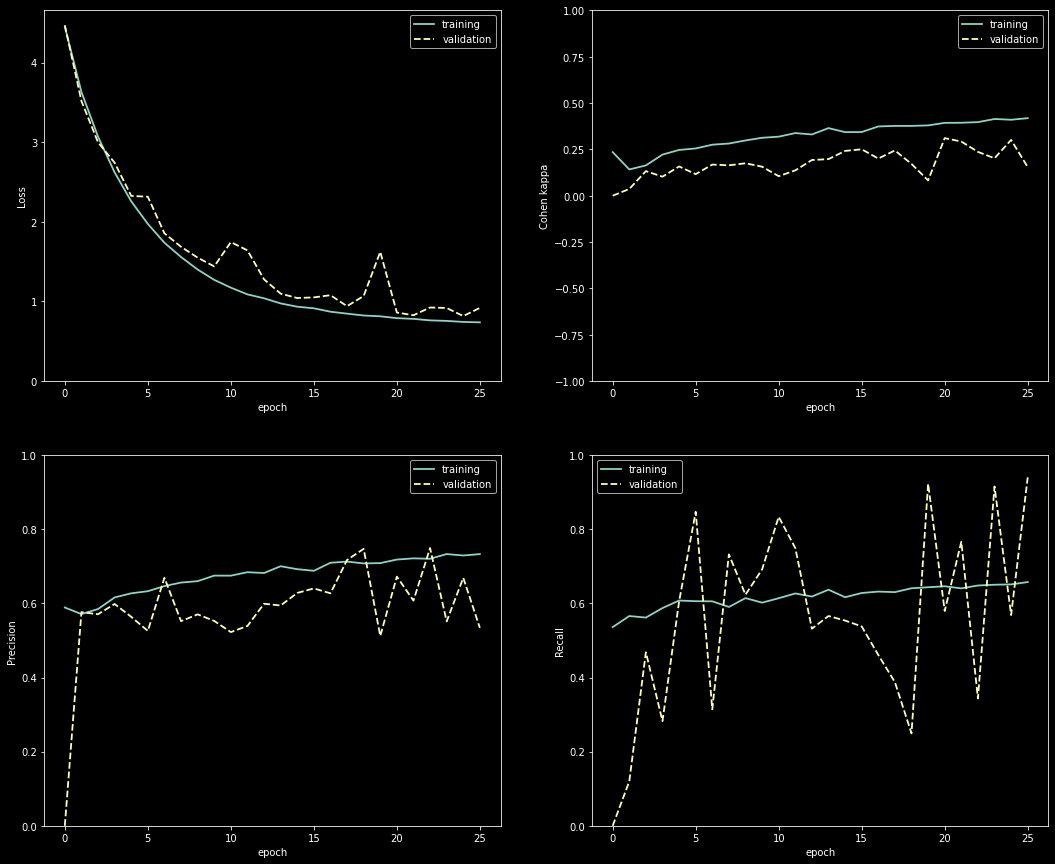

In [41]:
plot_metrics(history)

In [42]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

53/53 [==============================] - 14s 258ms/step - loss: 0.8545 - tp: 473.0000 - fp: 237.0000 - tn: 620.0000 - fn: 345.0000 - binary_acc: 0.6525 - precision: 0.6662 - recall: 0.5782 - f1_score: 0.6191 - roc_auc: 0.7017 - pr_auc: 0.7129 - cohen_kappa: 0.3026


In [43]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.8545465469360352
tp          : 473.0
fp          : 237.0
tn          : 620.0
fn          : 345.0
binary_acc  : 0.6525372862815857
precision   : 0.6661971807479858
recall      : 0.5782396197319031
f1_score    : 0.6191099882125854
roc_auc     : 0.7017300128936768
pr_auc      : 0.7129249572753906
cohen_kappa : 0.3026025891304016


In [44]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_SHOULDER-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_SHOULDER-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_SHOULDER-{model.count_params()}.h5")

Saving: ../models/cnn-XR_SHOULDER-3309921.h5


In [45]:
clean_up(model)

#### Only on XR_ELBOW study type

In [46]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 3945 validated image filenames belonging to 2 classes.


In [47]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 986 validated image filenames belonging to 2 classes.


In [48]:
model = make_cnn_model()

In [49]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
124/124 [==============================] - 43s 337ms/step - loss: 4.6880 - tp: 1024.0000 - fp: 823.0000 - tn: 2376.0000 - fn: 1397.0000 - binary_acc: 0.6050 - precision: 0.5544 - recall: 0.4230 - f1_score: 0.4799 - roc_auc: 0.6191 - pr_auc: 0.5547 - cohen_kappa: 0.1706 - val_loss: 4.3899 - val_tp: 44.0000 - val_fp: 67.0000 - val_tn: 516.0000 - val_fn: 359.0000 - val_binary_acc: 0.5680 - val_precision: 0.3964 - val_recall: 0.1092 - val_f1_score: 0.1712 - val_roc_auc: 0.5382 - val_pr_auc: 0.4304 - val_cohen_kappa: -0.0065 - lr: 1.0000e-04
Epoch 2/100
124/124 [==============================] - 42s 338ms/step - loss: 4.1780 - tp: 433.0000 - fp: 402.0000 - tn: 1940.0000 - fn: 1170.0000 - binary_acc: 0.6015 - precision: 0.5186 - recall: 0.2701 - f1_score: 0.3552 - roc_auc: 0.6059 - pr_auc: 0.4898 - cohen_kappa: 0.1065 - val_loss: 4.0523 - val_tp: 81.0000 - val_fp: 122.0000 - val_tn: 461.0000 - val_fn: 322.0000 - val_binary_acc: 0.5497 - val_precision: 0.3990 - val_recall: 0.2010 

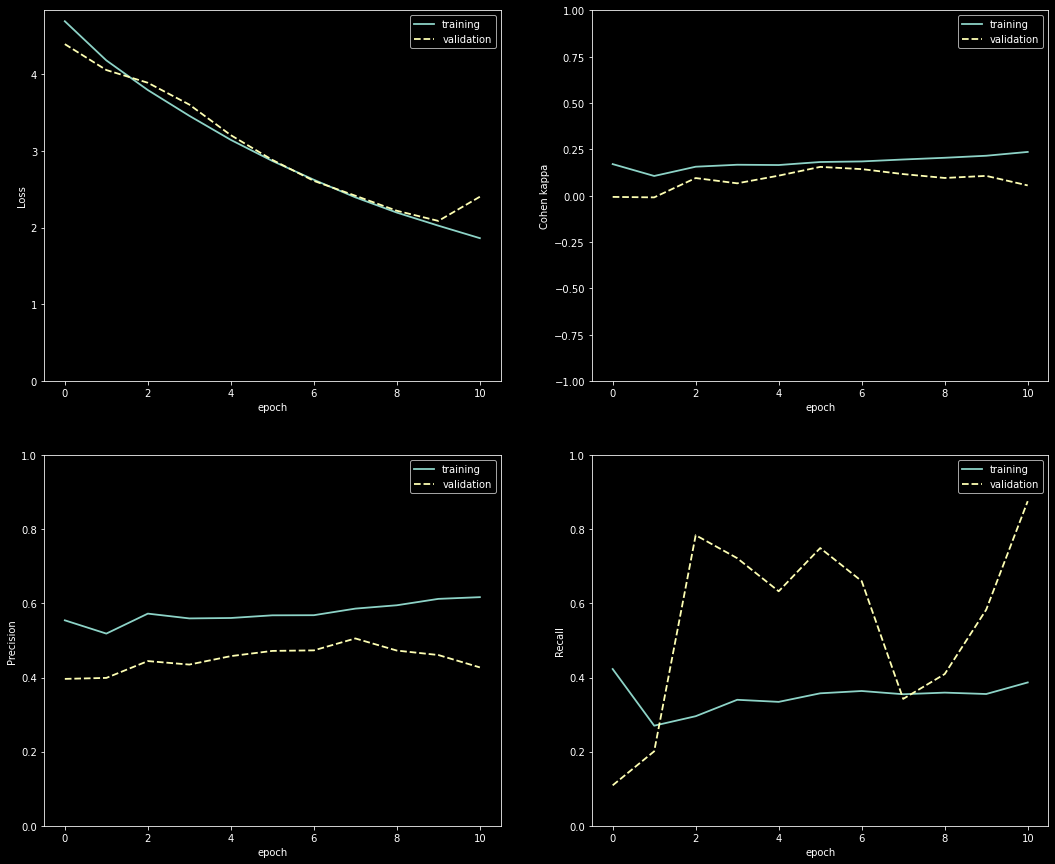

In [50]:
plot_metrics(history)

In [51]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

31/31 [==============================] - 8s 250ms/step - loss: 2.9070 - tp: 280.0000 - fp: 330.0000 - tn: 253.0000 - fn: 123.0000 - binary_acc: 0.5406 - precision: 0.4590 - recall: 0.6948 - f1_score: 0.5528 - roc_auc: 0.5860 - pr_auc: 0.4648 - cohen_kappa: 0.1193


In [52]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 2.906975507736206
tp          : 280.0
fp          : 330.0
tn          : 253.0
fn          : 123.0
binary_acc  : 0.540567934513092
precision   : 0.4590163826942444
recall      : 0.6947891116142273
f1_score    : 0.5528134703636169
roc_auc     : 0.5860080718994141
pr_auc      : 0.4648074805736542
cohen_kappa : 0.1192922592163086


In [53]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_ELBOW-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_ELBOW-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_ELBOW-{model.count_params()}.h5")

Saving: ../models/cnn-XR_ELBOW-3309921.h5


In [54]:
clean_up(model)

#### Only on XR_HUMERUS study type

In [55]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1018 validated image filenames belonging to 2 classes.


In [56]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 254 validated image filenames belonging to 2 classes.


In [57]:
model = make_cnn_model()

In [58]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
32/32 [==============================] - 14s 395ms/step - loss: 5.0634 - tp: 505.0000 - fp: 546.0000 - tn: 572.0000 - fn: 381.0000 - binary_acc: 0.5374 - precision: 0.4805 - recall: 0.5700 - f1_score: 0.5214 - roc_auc: 0.5522 - pr_auc: 0.4758 - cohen_kappa: 0.0801 - val_loss: 5.2435 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 138.0000 - val_fn: 116.0000 - val_binary_acc: 0.5433 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5344 - val_pr_auc: 0.5040 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 11s 339ms/step - loss: 4.6157 - tp: 214.0000 - fp: 177.0000 - tn: 358.0000 - fn: 269.0000 - binary_acc: 0.5619 - precision: 0.5473 - recall: 0.4431 - f1_score: 0.4897 - roc_auc: 0.6058 - pr_auc: 0.5581 - cohen_kappa: 0.1133 - val_loss: 6.1086 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 138.0000 - val_fn: 116.0000 - val_binary_acc: 0.5433 - val_precision: 0.0000e+00 

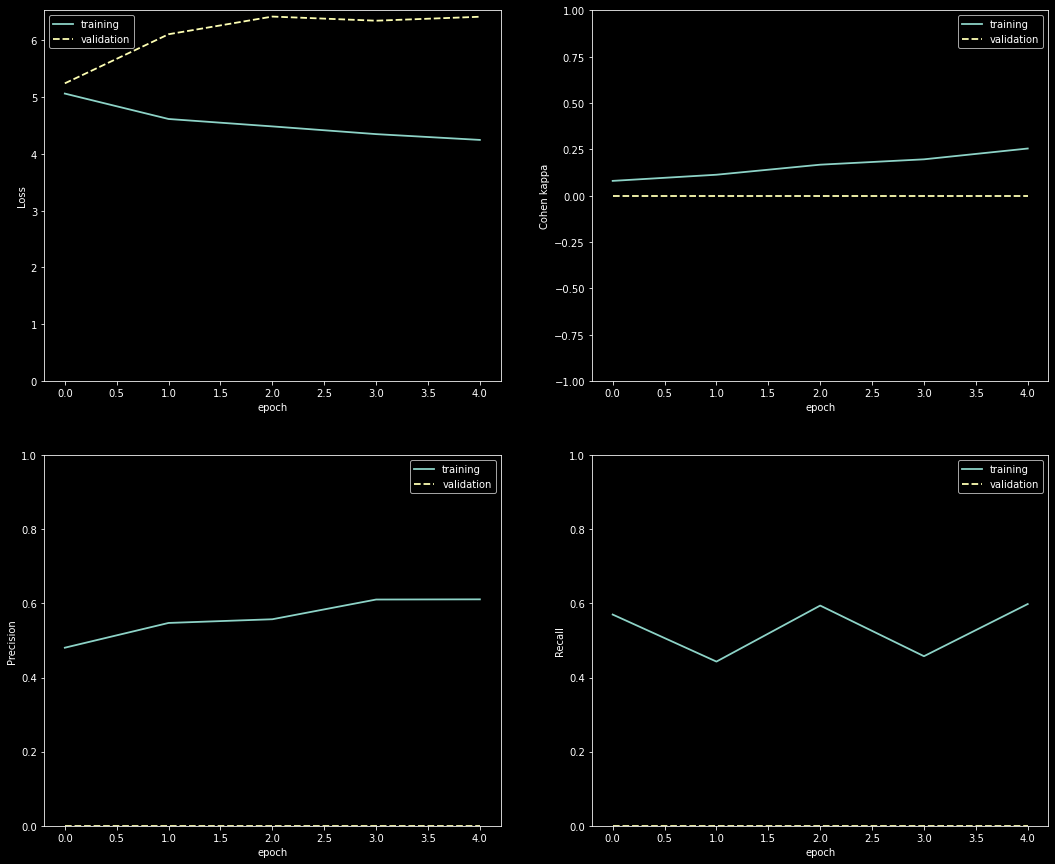

In [59]:
plot_metrics(history)

In [60]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

8/8 [==============================] - 2s 282ms/step - loss: 5.2452 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 138.0000 - fn: 116.0000 - binary_acc: 0.5433 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.5143 - pr_auc: 0.4677 - cohen_kappa: 0.0000e+00


In [61]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 5.245193958282471
tp          : 0.0
fp          : 0.0
tn          : 138.0
fn          : 116.0
binary_acc  : 0.5433070659637451
precision   : 0.0
recall      : 0.0
f1_score    : 0.0
roc_auc     : 0.5143053531646729
pr_auc      : 0.4676513671875
cohen_kappa : 0.0


In [62]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HUMERUS-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_HUMERUS-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_HUMERUS-{model.count_params()}.h5")

Saving: ../models/cnn-XR_HUMERUS-3309921.h5


In [63]:
clean_up(model)

#### Only on XR_HAND study type

In [64]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4435 validated image filenames belonging to 2 classes.


In [65]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1108 validated image filenames belonging to 2 classes.


In [66]:
model = make_cnn_model()

In [67]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
139/139 [==============================] - 50s 351ms/step - loss: 4.5036 - tp: 49.0000 - fp: 145.0000 - tn: 3256.0000 - fn: 1239.0000 - binary_acc: 0.7048 - precision: 0.2526 - recall: 0.0380 - f1_score: 0.0661 - roc_auc: 0.5349 - pr_auc: 0.2945 - cohen_kappa: -0.0062 - val_loss: 5.6524 - val_tp: 312.0000 - val_fp: 796.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.2816 - val_precision: 0.2816 - val_recall: 1.0000 - val_f1_score: 0.4394 - val_roc_auc: 0.4840 - val_pr_auc: 0.2828 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
139/139 [==============================] - 47s 335ms/step - loss: 3.8027 - tp: 18.0000 - fp: 23.0000 - tn: 3240.0000 - fn: 1154.0000 - binary_acc: 0.7346 - precision: 0.4390 - recall: 0.0154 - f1_score: 0.0297 - roc_auc: 0.5835 - pr_auc: 0.3304 - cohen_kappa: 0.0120 - val_loss: 4.1425 - val_tp: 312.0000 - val_fp: 796.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.2816 - val_precision: 0.2816 - val_reca

Epoch 16/100
139/139 [==============================] - 46s 329ms/step - loss: 0.9081 - tp: 83.0000 - fp: 36.0000 - tn: 3227.0000 - fn: 1089.0000 - binary_acc: 0.7463 - precision: 0.6975 - recall: 0.0708 - f1_score: 0.1286 - roc_auc: 0.6675 - pr_auc: 0.4440 - cohen_kappa: 0.0840 - val_loss: 0.9638 - val_tp: 64.0000 - val_fp: 120.0000 - val_tn: 676.0000 - val_fn: 248.0000 - val_binary_acc: 0.6679 - val_precision: 0.3478 - val_recall: 0.2051 - val_f1_score: 0.2581 - val_roc_auc: 0.5635 - val_pr_auc: 0.3235 - val_cohen_kappa: 0.0621 - lr: 1.0000e-04
Epoch 17/100
139/139 [==============================] - 45s 325ms/step - loss: 0.8891 - tp: 135.0000 - fp: 143.0000 - tn: 3120.0000 - fn: 1037.0000 - binary_acc: 0.7339 - precision: 0.4856 - recall: 0.1152 - f1_score: 0.1862 - roc_auc: 0.6559 - pr_auc: 0.3987 - cohen_kappa: 0.0944 - val_loss: 0.9395 - val_tp: 54.0000 - val_fp: 101.0000 - val_tn: 695.0000 - val_fn: 258.0000 - val_binary_acc: 0.6760 - val_precision: 0.3484 - val_recall: 0.1731 -

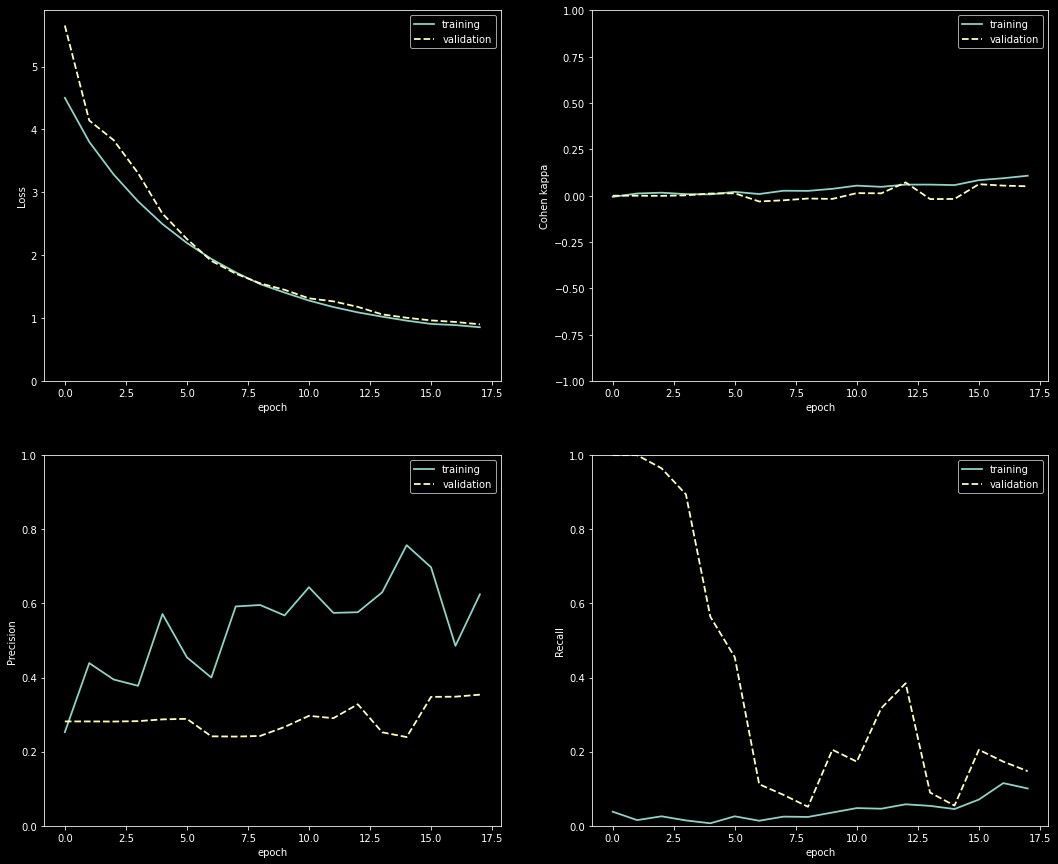

In [68]:
plot_metrics(history)

In [69]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

35/35 [==============================] - 9s 257ms/step - loss: 1.1683 - tp: 125.0000 - fp: 249.0000 - tn: 547.0000 - fn: 187.0000 - binary_acc: 0.6065 - precision: 0.3342 - recall: 0.4006 - f1_score: 0.3644 - roc_auc: 0.5759 - pr_auc: 0.3521 - cohen_kappa: 0.0828


In [70]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 1.168272614479065
tp          : 125.0
fp          : 249.0
tn          : 547.0
fn          : 187.0
binary_acc  : 0.6064981818199158
precision   : 0.3342246115207672
recall      : 0.4006410241127014
f1_score    : 0.3644314706325531
roc_auc     : 0.5759144425392151
pr_auc      : 0.35212424397468567
cohen_kappa : 0.08282321691513062


In [71]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HAND-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_HAND-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_HAND-{model.count_params()}.h5")

Saving: ../models/cnn-XR_HAND-3309921.h5


In [72]:
clean_up(model)

#### Only on XR_WRIST study type

In [73]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 7802 validated image filenames belonging to 2 classes.


In [74]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1950 validated image filenames belonging to 2 classes.


In [75]:
model = make_cnn_model()

In [76]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
244/244 [==============================] - 81s 325ms/step - loss: 4.4083 - tp: 1378.0000 - fp: 1433.0000 - tn: 3947.0000 - fn: 2152.0000 - binary_acc: 0.5976 - precision: 0.4902 - recall: 0.3904 - f1_score: 0.4346 - roc_auc: 0.5876 - pr_auc: 0.4700 - cohen_kappa: 0.1285 - val_loss: 4.7244 - val_tp: 769.0000 - val_fp: 1181.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.3944 - val_precision: 0.3944 - val_recall: 1.0000 - val_f1_score: 0.5656 - val_roc_auc: 0.5208 - val_pr_auc: 0.4059 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
244/244 [==============================] - 80s 328ms/step - loss: 3.5839 - tp: 1311.0000 - fp: 950.0000 - tn: 3634.0000 - fn: 1907.0000 - binary_acc: 0.6338 - precision: 0.5798 - recall: 0.4074 - f1_score: 0.4786 - roc_auc: 0.6548 - pr_auc: 0.5666 - cohen_kappa: 0.2094 - val_loss: 3.3715 - val_tp: 88.0000 - val_fp: 109.0000 - val_tn: 1072.0000 - val_fn: 681.0000 - val_binary_acc: 0.5949 - val_precision: 0.4467 - val_re

Epoch 16/100
244/244 [==============================] - 80s 328ms/step - loss: 0.7715 - tp: 1874.0000 - fp: 694.0000 - tn: 3890.0000 - fn: 1344.0000 - binary_acc: 0.7388 - precision: 0.7298 - recall: 0.5823 - f1_score: 0.6478 - roc_auc: 0.8043 - pr_auc: 0.7668 - cohen_kappa: 0.4443 - val_loss: 0.8347 - val_tp: 539.0000 - val_fp: 399.0000 - val_tn: 782.0000 - val_fn: 230.0000 - val_binary_acc: 0.6774 - val_precision: 0.5746 - val_recall: 0.7009 - val_f1_score: 0.6315 - val_roc_auc: 0.7664 - val_pr_auc: 0.7230 - val_cohen_kappa: 0.3497 - lr: 1.0000e-04
Epoch 17/100
244/244 [==============================] - 82s 335ms/step - loss: 0.7493 - tp: 1894.0000 - fp: 652.0000 - tn: 3932.0000 - fn: 1324.0000 - binary_acc: 0.7467 - precision: 0.7439 - recall: 0.5886 - f1_score: 0.6572 - roc_auc: 0.8122 - pr_auc: 0.7785 - cohen_kappa: 0.4607 - val_loss: 0.7563 - val_tp: 476.0000 - val_fp: 203.0000 - val_tn: 978.0000 - val_fn: 293.0000 - val_binary_acc: 0.7456 - val_precision: 0.7010 - val_recall: 0.

Epoch 31/100
244/244 [==============================] - 80s 329ms/step - loss: 0.6035 - tp: 2145.0000 - fp: 523.0000 - tn: 4061.0000 - fn: 1073.0000 - binary_acc: 0.7954 - precision: 0.8040 - recall: 0.6666 - f1_score: 0.7288 - roc_auc: 0.8639 - pr_auc: 0.8410 - cohen_kappa: 0.5669 - val_loss: 0.6664 - val_tp: 613.0000 - val_fp: 341.0000 - val_tn: 840.0000 - val_fn: 156.0000 - val_binary_acc: 0.7451 - val_precision: 0.6426 - val_recall: 0.7971 - val_f1_score: 0.7115 - val_roc_auc: 0.8443 - val_pr_auc: 0.8127 - val_cohen_kappa: 0.4879 - lr: 1.0000e-04
Epoch 32/100
244/244 [==============================] - 80s 327ms/step - loss: 0.5902 - tp: 2173.0000 - fp: 507.0000 - tn: 4077.0000 - fn: 1045.0000 - binary_acc: 0.8011 - precision: 0.8108 - recall: 0.6753 - f1_score: 0.7369 - roc_auc: 0.8699 - pr_auc: 0.8475 - cohen_kappa: 0.5791 - val_loss: 0.6153 - val_tp: 466.0000 - val_fp: 96.0000 - val_tn: 1085.0000 - val_fn: 303.0000 - val_binary_acc: 0.7954 - val_precision: 0.8292 - val_recall: 0.

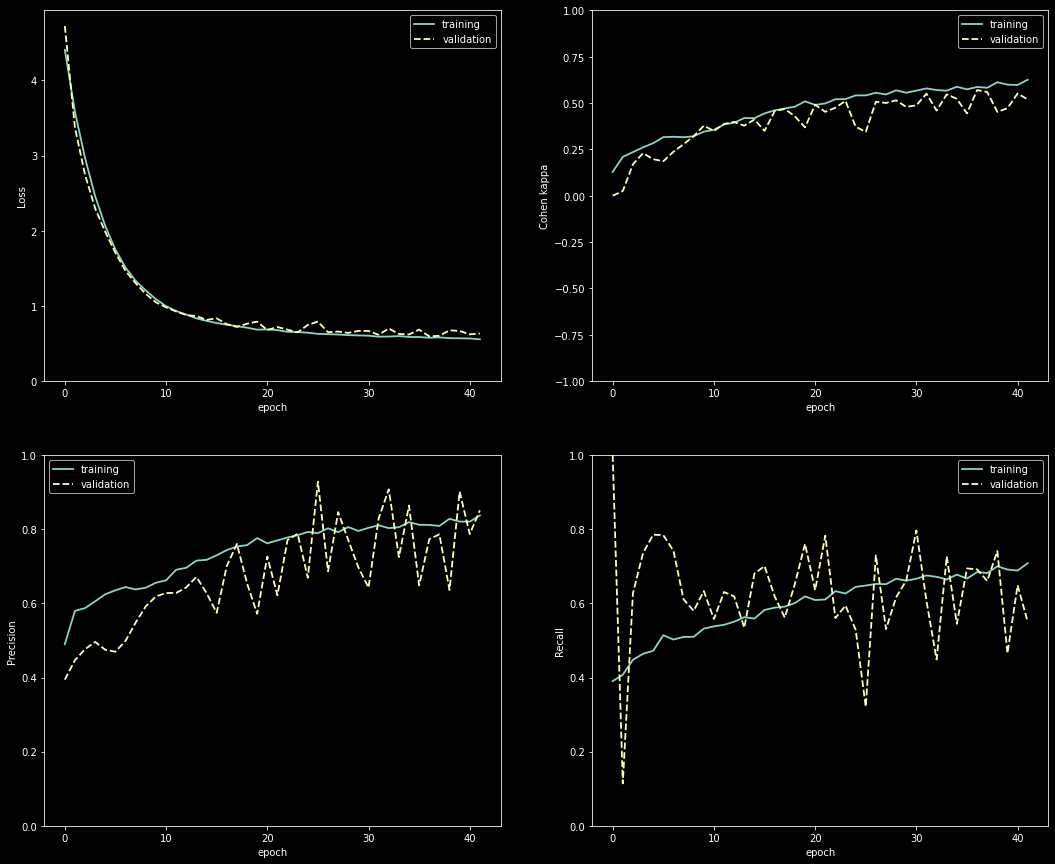

In [77]:
plot_metrics(history)

In [78]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

61/61 [==============================] - 16s 262ms/step - loss: 0.5895 - tp: 523.0000 - fp: 144.0000 - tn: 1037.0000 - fn: 246.0000 - binary_acc: 0.8000 - precision: 0.7841 - recall: 0.6801 - f1_score: 0.7284 - roc_auc: 0.8624 - pr_auc: 0.8401 - cohen_kappa: 0.5714


In [79]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.5895422101020813
tp          : 523.0
fp          : 144.0
tn          : 1037.0
fn          : 246.0
binary_acc  : 0.800000011920929
precision   : 0.7841079235076904
recall      : 0.6801040172576904
f1_score    : 0.7284122109413147
roc_auc     : 0.8623711466789246
pr_auc      : 0.840066134929657
cohen_kappa : 0.5713933706283569


In [80]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_WRIST-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_WRIST-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_WRIST-{model.count_params()}.h5")

Saving: ../models/cnn-XR_WRIST-3309921.h5


In [81]:
clean_up(model)

#### Only on XR_FOREARM study type

In [82]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1460 validated image filenames belonging to 2 classes.


In [83]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 365 validated image filenames belonging to 2 classes.


In [84]:
model = make_cnn_model()

In [85]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
46/46 [==============================] - 19s 382ms/step - loss: 4.9469 - tp: 722.0000 - fp: 398.0000 - tn: 1706.0000 - fn: 584.0000 - binary_acc: 0.7120 - precision: 0.6446 - recall: 0.5528 - f1_score: 0.5952 - roc_auc: 0.7417 - pr_auc: 0.6810 - cohen_kappa: 0.3738 - val_loss: 4.7134 - val_tp: 124.0000 - val_fp: 241.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.3397 - val_precision: 0.3397 - val_recall: 1.0000 - val_f1_score: 0.5072 - val_roc_auc: 0.5975 - val_pr_auc: 0.4055 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - 15s 332ms/step - loss: 4.5770 - tp: 205.0000 - fp: 198.0000 - tn: 725.0000 - fn: 332.0000 - binary_acc: 0.6370 - precision: 0.5087 - recall: 0.3818 - f1_score: 0.4362 - roc_auc: 0.6164 - pr_auc: 0.4767 - cohen_kappa: 0.1764 - val_loss: 4.5032 - val_tp: 41.0000 - val_fp: 53.0000 - val_tn: 188.0000 - val_fn: 83.0000 - val_binary_acc: 0.6274 - val_precision: 0.4362 - val_recall: 0.3306 -

Epoch 16/100
46/46 [==============================] - 16s 339ms/step - loss: 2.7647 - tp: 216.0000 - fp: 116.0000 - tn: 807.0000 - fn: 321.0000 - binary_acc: 0.7007 - precision: 0.6506 - recall: 0.4022 - f1_score: 0.4971 - roc_auc: 0.7168 - pr_auc: 0.5979 - cohen_kappa: 0.3005 - val_loss: 2.8141 - val_tp: 32.0000 - val_fp: 24.0000 - val_tn: 217.0000 - val_fn: 92.0000 - val_binary_acc: 0.6822 - val_precision: 0.5714 - val_recall: 0.2581 - val_f1_score: 0.3556 - val_roc_auc: 0.6479 - val_pr_auc: 0.4898 - val_cohen_kappa: 0.1828 - lr: 1.0000e-04
Epoch 17/100
46/46 [==============================] - 16s 339ms/step - loss: 2.6782 - tp: 231.0000 - fp: 127.0000 - tn: 796.0000 - fn: 306.0000 - binary_acc: 0.7034 - precision: 0.6453 - recall: 0.4302 - f1_score: 0.5162 - roc_auc: 0.7204 - pr_auc: 0.5932 - cohen_kappa: 0.3145 - val_loss: 2.7565 - val_tp: 85.0000 - val_fp: 113.0000 - val_tn: 128.0000 - val_fn: 39.0000 - val_binary_acc: 0.5836 - val_precision: 0.4293 - val_recall: 0.6855 - val_f1_s

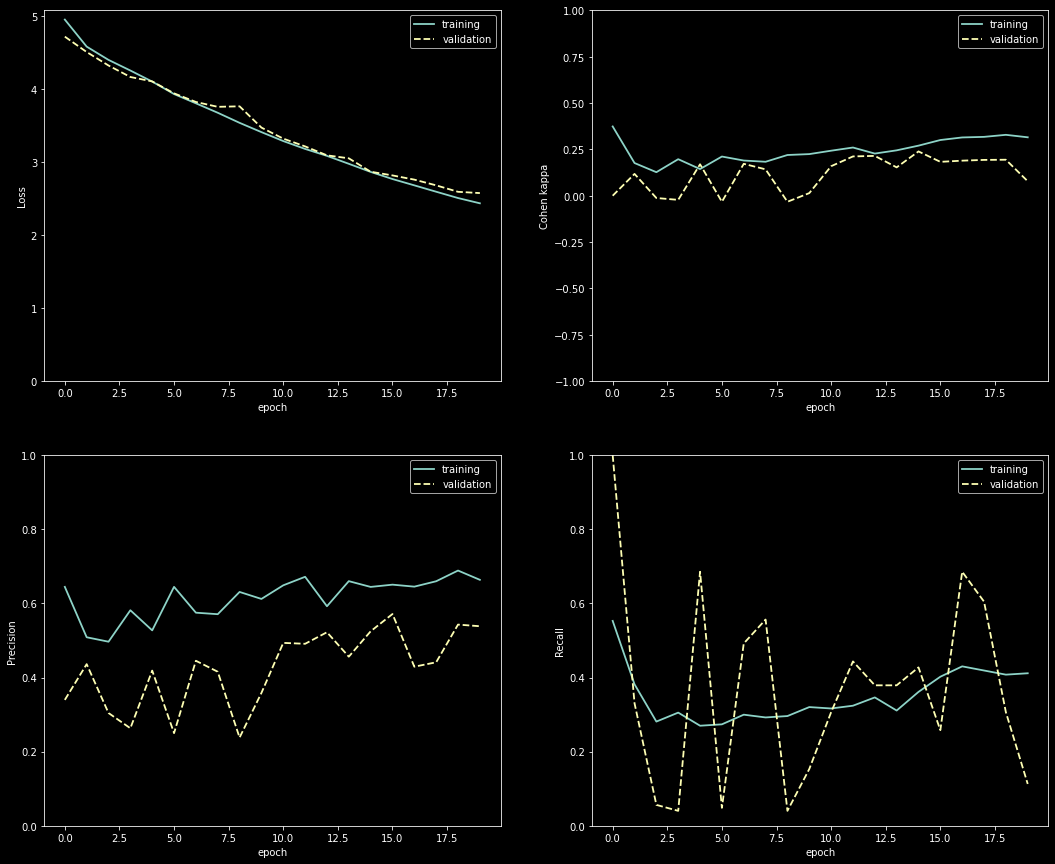

In [86]:
plot_metrics(history)

In [87]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

12/12 [==============================] - 3s 257ms/step - loss: 2.8608 - tp: 55.0000 - fp: 49.0000 - tn: 192.0000 - fn: 69.0000 - binary_acc: 0.6767 - precision: 0.5288 - recall: 0.4435 - f1_score: 0.4825 - roc_auc: 0.6669 - pr_auc: 0.4933 - cohen_kappa: 0.2500


In [88]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 2.86083984375
tp          : 55.0
fp          : 49.0
tn          : 192.0
fn          : 69.0
binary_acc  : 0.6767123341560364
precision   : 0.5288461446762085
recall      : 0.44354838132858276
f1_score    : 0.48245611786842346
roc_auc     : 0.666928768157959
pr_auc      : 0.49326080083847046
cohen_kappa : 0.2500174045562744


In [89]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FOREARM-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_FOREARM-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_FOREARM-{model.count_params()}.h5")

Saving: ../models/cnn-XR_FOREARM-3309921.h5


In [90]:
clean_up(model)

#### Only on XR_FINGER study type

In [91]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4085 validated image filenames belonging to 2 classes.


In [92]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1021 validated image filenames belonging to 2 classes.


In [93]:
model = make_cnn_model()

In [94]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
128/128 [==============================] - 45s 335ms/step - loss: 4.6289 - tp: 698.0000 - fp: 638.0000 - tn: 2116.0000 - fn: 998.0000 - binary_acc: 0.6324 - precision: 0.5225 - recall: 0.4116 - f1_score: 0.4604 - roc_auc: 0.6504 - pr_auc: 0.4918 - cohen_kappa: 0.1875 - val_loss: 6.1567 - val_tp: 396.0000 - val_fp: 625.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.3879 - val_precision: 0.3879 - val_recall: 1.0000 - val_f1_score: 0.5589 - val_roc_auc: 0.5234 - val_pr_auc: 0.4109 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
128/128 [==============================] - 41s 317ms/step - loss: 4.1013 - tp: 674.0000 - fp: 524.0000 - tn: 1989.0000 - fn: 898.0000 - binary_acc: 0.6519 - precision: 0.5626 - recall: 0.4288 - f1_score: 0.4866 - roc_auc: 0.6885 - pr_auc: 0.5504 - cohen_kappa: 0.2305 - val_loss: 4.7473 - val_tp: 396.0000 - val_fp: 625.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.3879 - val_precision: 0.3879 - val_reca

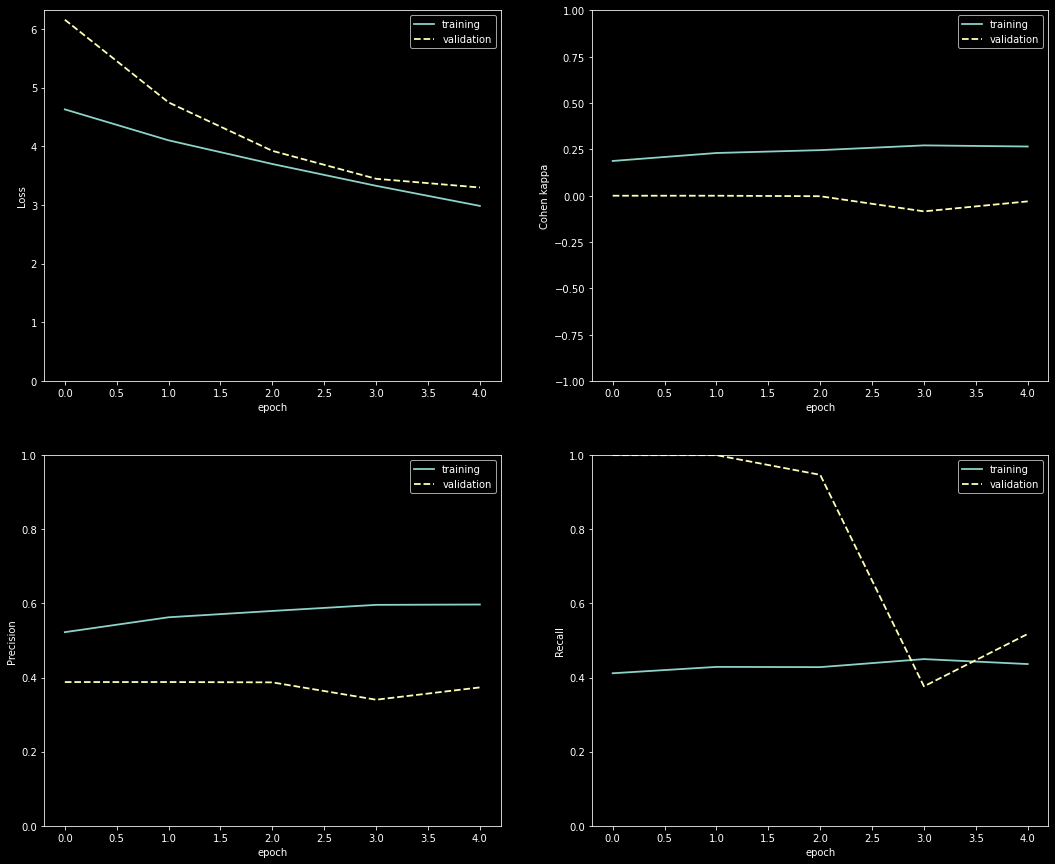

In [95]:
plot_metrics(history)

In [96]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

32/32 [==============================] - 8s 261ms/step - loss: 6.1556 - tp: 396.0000 - fp: 625.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - binary_acc: 0.3879 - precision: 0.3879 - recall: 1.0000 - f1_score: 0.5589 - roc_auc: 0.5215 - pr_auc: 0.3938 - cohen_kappa: 0.0000e+00


In [97]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 6.155616760253906
tp          : 396.0
fp          : 625.0
tn          : 0.0
fn          : 0.0
binary_acc  : 0.38785505294799805
precision   : 0.38785505294799805
recall      : 1.0
f1_score    : 0.5589272975921631
roc_auc     : 0.5215252637863159
pr_auc      : 0.39378654956817627
cohen_kappa : 0.0


In [98]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FINGER-?.h5',
#     custom_objects={'F1Score': F1Score}
# )
print(f"Saving: ../models/cnn-XR_FINGER-{model.count_params()}.h5")
model.save(f"../models/cnn-XR_FINGER-{model.count_params()}.h5")

Saving: ../models/cnn-XR_FINGER-3309921.h5


In [99]:
clean_up(model)